In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Health Related Federal Grant Tracking
----------------------------------------------------------------

The US government invests billions each year into the health research. The "open government" initiative provides more transparency into the governmental activities in the health related sector. Grant application data from NIH, ACF, AHRQ, CDC, HRSA, FDA, and VA are now easily accessible. With that large amount of data, we can now track the trend of the health research according to the amount of grant money. What research topics/areaes get more attractive? How have they been changing over the years? What area in the health sector will likely be the next breakthrough? I will try to explore those questions from the grant application database. 

First of all, the database called NIH ExPORTER is accesible [here](https://exporter.nih.gov/ExPORTER_Catalog.aspx). A total of 7.3 GB data were downloaded. 

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import os
import dill
from tqdm import tqdm_notebook
import gensim
import pickle
import pyLDAvis.gensim
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint
import matplotlib.pyplot as plt
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [22]:
from tqdm import tqdm_notebook
fns = os.listdir('./Data/PRJABS/')
fns.sort()
fns = ['./Data/PRJABS/'+x for x in fns]
proj_ABS = [pd.read_csv(fn,header = 0,dtype = {'APPLICATION_ID': str,'ABSTRACT_TEXT': str},engine = 'python') for fn in tqdm_notebook(fns)]


HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

In [58]:
#add fiscal year number,fix the data type
for i in range(len(proj_ABS)):
    proj_ABS[i]['FY'] = i + 1985
    proj_ABS[i].apply(str)
#concate the whole table
proj_ABS = pd.concat(proj_ABS)

In [90]:
#all the non-missing entries
proj_ABS = proj_ABS[proj_ABS['ABSTRACT_TEXT']!= 'nan']

In [93]:
dill.dump(proj_ABS,open('abstracts.dill','wb'))

In [4]:
proj_ABS = dill.load(open('abstracts.dill','rb'))

# Unsupervised topic modeling with the abstracts
With all the non-missing text files in the dataset, I will start the NLP to extract some basic labels. I will try to set the number of topics ahead of time to evaluate what is the best number of topics. I will mainly use the Latent Dirichlet Allocation (LDA) topic modeling technique.

The abstracts will first be cleaned. Steps include parsing and tokenization, whitespace striping, lowering the words, word lemmatizing, and stop-words cleaning. The bags of word tokens will then be ready for the next step.  

In [3]:
text = proj_ABS['ABSTRACT_TEXT']
text_update = text[:1763542].append(text[1763549:]) #delete those entries that cause a lot of troubles

In [54]:
t_2017 = proj_ABS.query('FY == 2017')[['ABSTRACT_TEXT']]
t_2017[29384:29391] = 'nan' #need to update this and the followin line to pd.drop
t_2017 = t_2017[t_2017['ABSTRACT_TEXT'] != 'nan']
t_2017 = [prepare_text_for_lda(x) for x in tqdm_notebook(t_2017['ABSTRACT_TEXT'])]

HBox(children=(IntProgress(value=0, max=72410), HTML(value='')))

In [69]:
#Text Cleaning
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

#word lemmatize to get the root word
import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

#clean stop words
#nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

#ensemble function
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [8]:
n = len(text)//10
n,len(text),2*n

(180658, 1806580, 361316)

In [13]:
n = len(text)//10
text_data1 = [prepare_text_for_lda(abs) for abs in tqdm_notebook(list(text)[:n])]

HBox(children=(IntProgress(value=0, max=180658), HTML(value='')))

In [14]:
dill.dump(text_data1,open('abs_tokens1.dill','wb'))

In [18]:
text_data1 = dill.load(open('abs_tokens1.dill','rb'))

In [16]:
text_data2 = [prepare_text_for_lda(abs) for abs in tqdm_notebook(list(text)[n:2*n])]

HBox(children=(IntProgress(value=0, max=180658), HTML(value='')))

In [17]:
dill.dump(text_data2,open('abs_tokens2.dill','wb'))

In [8]:
text_data2 = dill.load(open('abs_tokens2.dill','rb'))

In [10]:
text_data3 = [prepare_text_for_lda(abs) for abs in tqdm_notebook(list(text)[2*n:3*n])]

HBox(children=(IntProgress(value=0, max=180658), HTML(value='')))

In [11]:
dill.dump(text_data3,open('abs_tokens3.dill','wb'))

In [9]:
text_data3 = dill.load(open('abs_tokens3.dill','rb'))

In [13]:
text_data4 = [prepare_text_for_lda(abs) for abs in tqdm_notebook(list(text)[3*n:4*n])]

HBox(children=(IntProgress(value=0, max=180658), HTML(value='')))

In [14]:
dill.dump(text_data4,open('abs_tokens4.dill','wb'))

In [ ]:
text_data4 = dill.load(open('abs_tokens4.dill','rb'))

In [9]:
text_data5 = [prepare_text_for_lda(abs) for abs in tqdm_notebook(list(text)[4*n:5*n])]

HBox(children=(IntProgress(value=0, max=180658), HTML(value='')))

In [10]:
dill.dump(text_data5,open('abs_tokens5.dill','wb'))

In [11]:
text_data6 = [prepare_text_for_lda(abs) for abs in tqdm_notebook(list(text)[5*n:6*n])]

HBox(children=(IntProgress(value=0, max=180658), HTML(value='')))

In [12]:
dill.dump(text_data6,open('abs_tokens6.dill','wb'))

In [9]:
text_data7 = [prepare_text_for_lda(abs) for abs in tqdm_notebook(list(text)[6*n:7*n])]

HBox(children=(IntProgress(value=0, max=180658), HTML(value='')))

In [10]:
dill.dump(text_data7,open('abs_tokens7.dill','wb'))

In [9]:
text_data8 = [prepare_text_for_lda(abs) for abs in tqdm_notebook(list(text)[7*n:8*n])]

HBox(children=(IntProgress(value=0, max=180658), HTML(value='')))

In [10]:
dill.dump(text_data8,open('abs_tokens8.dill','wb'))

In [9]:
text_data9 = [prepare_text_for_lda(abs) for abs in tqdm_notebook(list(text)[8*n:9*n])]

HBox(children=(IntProgress(value=0, max=180658), HTML(value='')))

In [10]:
dill.dump(text_data9,open('abs_tokens9.dill','wb'))

In [17]:
text_data10 = [prepare_text_for_lda(abs) for abs in tqdm_notebook(list(text)[9*n:9*n+137620])]

HBox(children=(IntProgress(value=0, max=137620), HTML(value='')))

In [23]:
9*n+137620,9*n+137627

(1763542, 1763549)

In [77]:
#list(text)[9*n+137620:9*n+137627]

In [18]:
dill.dump(text_data10,open('abs_tokens10.dill','wb'))

In [21]:
text_data11 = [prepare_text_for_lda(abs) for abs in tqdm_notebook(list(text)[9*n+137627:9*n+137665])]

HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

In [24]:
dill.dump(text_data11,open('abs_tokens11.dill','wb'))

In [11]:
text_data12 = [prepare_text_for_lda(abs) for abs in tqdm_notebook(list(text)[9*n+137665:])]

HBox(children=(IntProgress(value=0, max=42993), HTML(value='')))

In [12]:
dill.dump(text_data12,open('abs_tokens12.dill','wb'))

In [78]:
#len(text)

In [5]:
text_update = text[:1763542].append(text[1763549:]) #delete those entries that cause a lot of troubles

NameError: name 'text' is not defined

In [27]:
len(text_update)

1806573

In [ ]:
text_data = [prepare_text_for_lda(abs) for abs in tqdm_notebook(list(text_update))]

HBox(children=(IntProgress(value=0, max=1806573), HTML(value='')))

In [ ]:
dill.dump(text_data,open('abs_tokens.dill','wb'))

Now that, the bags of words are ready. We can start getting the topics out of them. 

In [1]:
len(text_data1)
#text_data1[:2]

NameError: name 'text_data1' is not defined

In [10]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data1)
corpus = [dictionary.doc2bow(text) for text in tqdm_notebook(text_data1)]

HBox(children=(IntProgress(value=0, max=180658), HTML(value='')))

In [30]:
pickle.dump(corpus, open('corpus1.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [ ]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

In [18]:
ldamodel.get_document_topics(corpus[10])

[(2, 0.99246734)]

In [4]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus1.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

/opt/conda/envs/data3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [8]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus1.pkl', 'rb'))
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=5)
ldamodel.save('model10.gensim')
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

/opt/conda/envs/data3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [24]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

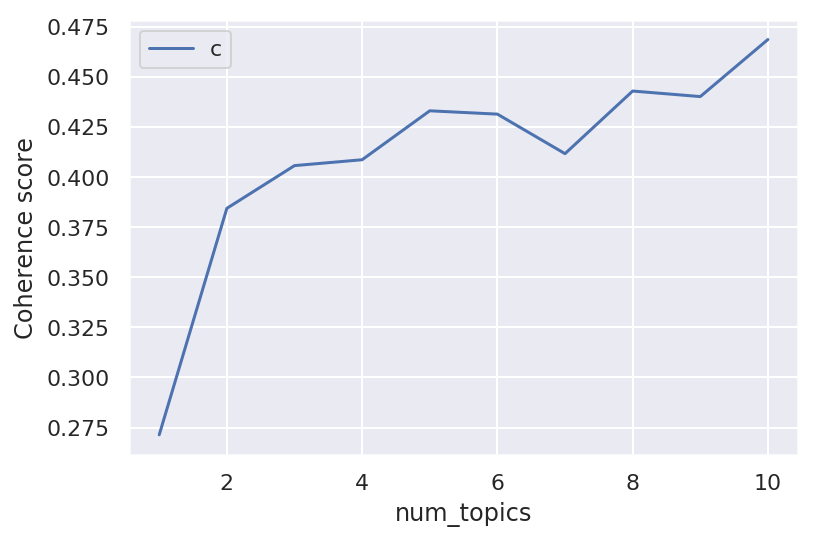

In [27]:
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=text_data1, limit=11)

In [11]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)
lsimodel.show_topics(num_topics=5)
lsitopics = lsimodel.show_topics(formatted=False)

In [12]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdptopics = hdpmodel.show_topics(formatted=False)

In [13]:
len(hdptopics)

20

In [15]:
lsimodel.save('lsi10.gensim')
hdpmodel.save('hdp10.gensim')

In [16]:
ldatopics = ldamodel.show_topics(formatted=False)

lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

In [19]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=text_data1, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=text_data1, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=text_data1, dictionary=dictionary, window_size=10).get_coherence()

In [20]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

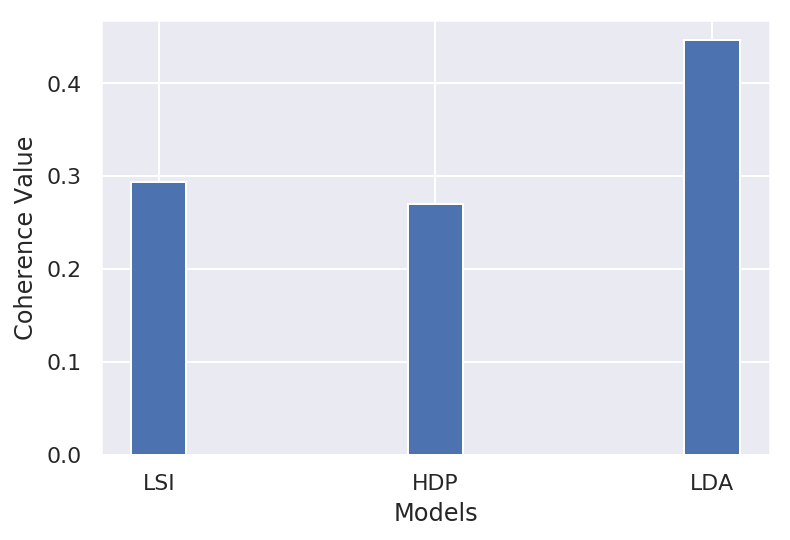

In [23]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])

In [6]:
ldamodel = gensim.models.ldamodel.LdaModel.load('model10.gensim')
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus1.pkl', 'rb'))
topics_1=[sorted(a,key=lambda x: -x[1]) for a in ldamodel.get_document_topics(corpus)]

In [24]:
topics_1=[a[0] for a in topics_1]

In [25]:
topics_1[4]

6

In [36]:
ldamodel.get_document_topics(corpus[4])

[(4, 0.2772279), (6, 0.54607046), (8, 0.049855266), (9, 0.11934461)]

In [74]:
from gensim import corpora
from gensim.models import TfidfModel
words_rm = ['program','research','training','health','center','support','investigator',
            'community','resource','trainee','science','student','administrative',
            'abstract','project','career','faculty','services','university','contract',
            'mentor','provide','meeting','school','director','collaboration','facility',
            'institute','department','researcher','biology','member']
t_2017 = proj_ABS.query('FY == 2017')[['ABSTRACT_TEXT']]
#t_2017.drop(t_2017.index([range(29384,29391)]),inplace=True)
t_2017[29384:29391] = 'nan' #need to update this and the followin line to pd.drop
t_2017 = t_2017[t_2017['ABSTRACT_TEXT'] != 'nan']
t_2017 = [prepare_text_for_lda(x) for x in tqdm_notebook(t_2017['ABSTRACT_TEXT'])]
#t_2017 = [[word for word in abs if word not in words_rm] for abs in t_2017]
dict_2017 = corpora.Dictionary(t_2017)
corpus_2017 = [dict_2017.doc2bow(text) for text in tqdm_notebook(t_2017)]
model = TfidfModel(corpus_2017)
vector_2017 = model[corpus_2017]

HBox(children=(IntProgress(value=0, max=72410), HTML(value='')))

HBox(children=(IntProgress(value=0, max=72410), HTML(value='')))

In [75]:
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(vector_2017, num_topics = NUM_TOPICS, id2word=dict_2017, passes=5)
#ldamodel.save('model10.gensim')

lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus_2017, dict_2017, sort_topics=True)
pyLDAvis.display(lda_display)

/opt/conda/envs/data3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [2]:
pickle.dump(corpus_2017, open('corpus_2017.pkl', 'wb'))
dict_2017.save('dict_2017.gensim')
ldamodel.save('model5_2017.gensim')

NameError: name 'corpus_2017' is not defined

In [5]:
corpus_2017 = pickle.load(open('corpus_2017.pkl','rb'))
dict_2017 = gensim.corpora.Dictionary.load('dict_2017.gensim')
model = TfidfModel(corpus_2017)
vector_2017 = model[corpus_2017]
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(vector_2017, num_topics = NUM_TOPICS, id2word=dict_2017, passes=5)
#ldamodel.save('model10.gensim')



/opt/conda/envs/data3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [7]:
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus_2017, dict_2017, sort_topics=True)
pyLDAvis.display(lda_display)

/opt/conda/envs/data3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [6]:
ldamodel.save('model10_2017.gensim')

# What much money had been spent on each topic?
With the topic modeling taken cared, we can start dig into the problem a little bit further.

In [38]:
fns = os.listdir('./Data/PRJ/')
fns.sort()
fns = ['./Data/PRJ/'+x for x in fns]
proj = [pd.read_csv(fn,header = 0,usecols = ['APPLICATION_ID','FY','TOTAL_COST','TOTAL_COST_SUB_PROJECT'],dtype = {'APPLICATION_ID': str,'FY':str,'TOTAL_COST': float,'TOTAL_COST_SUB_PROJECT':float},engine = 'python') for fn in tqdm_notebook(fns)]

HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

In [76]:
proj_ABS_1=proj_ABS[:len(topics_1)]
len(proj_ABS_1)
assert len(proj_ABS_1) == len(topics_1)

In [77]:
proj_ABS_1.insert(loc=3,column='topic',value=topics_1)

In [78]:
proj_ABS_1 = proj_ABS_1.drop('ABSTRACT_TEXT',axis=1)

In [69]:
proj=pd.concat(proj)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [70]:
proj_ABS_1.set_index('APPLICATION_ID',inplace=True)
proj.set_index('APPLICATION_ID',inplace=True)

In [72]:
#proj_ABS_1=proj_ABS_1.drop('FY',axis=1)
proj_1 = proj_ABS_1.join(proj,how='left',lsuffix='a',rsuffix='b')


In [79]:
proj_ABS_1.tail()

,APPLICATION_ID,FY,topic
14653,3115795,1991,0
14655,3480086,1991,5
14656,3115877,1991,9
14657,3509455,1991,8
14658,3114917,1991,4
